<a href="https://colab.research.google.com/github/finardi/tutos/blob/master/TF_IDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
#basic
import pandas as pd
import numpy as np
from collections import Counter
from itertools import combinations

#get unique ids
import uuid 

#sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from scipy.spatial import distance # 1- cos_similarity

#plots
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

In [59]:
samples = ["Battletoads é um novo jogo da famosa série dos sapos briguentos que \
            ficaram conhecidos como protagonistas de um dos games mais difíceis de \
            todos os tempos no Nintendo 8 Bits e Mega Drive. O título mais recente \
            traz os sapos Rash, Zitz.", "Pimple em uma aventura original no estilo \
            beat'em up que remete ao estilo do clássico Battletoads, mas expande a \
            franquia com novidades.", "O novo jogo é um reboot da série, que se \
            passa muitos anos após os games originais, quando os Battletoads não \
            são mais famosos em seu universo.", "Para recobrar sua fama, eles se \
            unem à antiga nêmesis.", "Dark Queen para enfrentar a ameaça dos \
            Topians, uma raça alienígena abstrata.", "A jogabilidade traz \
            multiplayer cooperativo para até três jogadores em combate, cada qual \
            com um toad, e também em minigames como os desafios de motos voadoras.",
            "Todo o visual do game é desenhado à mão e há 30 minutos de animação \
            com cenas da história.","O OBS Studio é um programa usado para realizar\
            transmissões ao vivo pela internet.", "O programa permite que os \
            streamers adicionem o chat box em suas lives.", "Ao exibir os \
            comentários na transmissão, a ferramenta, promove conexão com o \
            público e também torna as transmissões mais profissionais.", "Veja, a \
            seguir, como configurar a chat box no OBS Studio.", "Baixar vídeos do \
            Google Drive é possível para salvar o arquivo no celular e ter acesso \
            sem Internet (offline). Na versão do aplicativo para Android, o \
            conteúdo é salvo na galeria de fotos.", "Usuários de iPhone podem \
            salvar as imagens no app Arquivos, que é nativo do sistema da Apple.", 
            "SmartEgg Pro é um controle remoto universal compatível com mais de 30 \
            mil dispositivos, segundo a fabricante.", "O acessório, que bateu a \
            meta de financiamento coletivo no Kickstarter, funciona por meio de \
            sinal infravermelho, além de Wi-Fi e Bluetooth, funcionando em 360 \
            graus para controlar dispositivos compatíveis.", "Os ajustes podem ser \
            feitos por meio de um app para celular, permitindo unificar o controle \
            de TV, sistema de som, ar-condicionado ou até mesmo aparelhos de casa \
            conectada pela mesma interface.", "O SmartEgg Pro tem preço inicial de \
            US$ 59, algo em torno de R$ 320 na cotação atual, e seu frete é grátis \
            para o Brasil.", "As entregas, por sua vez, estão previstas para \
            dezembro de 2020."]

# gerando IDS alpha numéricos
ids_ = [uuid.uuid4().hex[:6].upper() for i in range(len(samples))]
                                                    
df = pd.DataFrame({'ID':ids_, 'TEXT': samples})            
df

,ID,TEXT
0,F2171C,Battletoads é um novo jogo da famosa série dos...
1,E595BC,Pimple em uma aventura original no estilo ...
2,145CEB,"O novo jogo é um reboot da série, que se ..."
3,B01D76,"Para recobrar sua fama, eles se un..."
4,1EE6D3,Dark Queen para enfrentar a ameaça dos ...
5,AC789B,A jogabilidade traz multiplayer co...
6,9EC13B,Todo o visual do game é desenhado à mão e há 3...
7,73178E,O OBS Studio é um programa usado para realizar...
8,4C57A7,O programa permite que os streamer...
9,3222AD,Ao exibir os comentários na transm...


In [60]:
def pt_stop_words(path):
    #read_file with stop_words
    with open(path) as f:
        stop_words = f.readlines()

    pt_stop_words = []
    for w in stop_words:
        #remove break lines and spaces
        pt_stop_words.append(w.replace('\n', '').strip())

    return pt_stop_words

path = '/content/drive/My Drive/Colab Notebooks/Texts-Processing/stopwords.txt'
stop_words = pt_stop_words(path)

In [61]:
def tf_idf(text, ngrams=2):
    vectorizer = TfidfVectorizer(
        ngram_range=(ngrams,ngrams), 
        # stop_words=stop_words,
        )
    X = vectorizer.fit_transform(text)
    return X.toarray()

In [62]:
class CosDist:
    """
    Entrada:
        -   dataframe com os IDs dos documentos
        -   embeddings de algum método: BERT, TF-IDF, W2V
    
    Executa: 
        -   a distãncia do cosseno: 1 - similaridade

    Saída:
        -   dataframe com as cols.: 
                ID1: id do 1o documento
                ID2: id do 2o documento
                COS_DIST: distância do cossendo entre (1o e 2o) documento. 
    """
    
    def __init__(self, df, embs):
        self.embs = embs
        self.df = df.copy()
    
    def tuple_array_cos(self):
        
        #combinatória dos pares i,j para todo (i !=k)
        comb = np.fromiter(combinations(range(self.embs.shape[0]), 2), dtype='i,i')
        
        #ids dos documentos
        ids = self.df.ID.values
        
        #ids do 1o documento
        ids1 = ids[comb['f0']]

        #ids do 2o documento
        ids2 = ids[comb['f1']]
        
        #ids em forma de tupla (1o documento, 2o documento)
        tuple_ids = [(ids1[i], ids2[i]) for i in range(ids1.shape[0])]

        #para guardar as distâncias do cosseno
        cos_d = []
        #------------------------------------------------------------------
        #para todos os pares (i,j)
        for j, id in enumerate(comb):

            # calcula a distância com o scipy
            cos_dist = distance.cosine(self.embs[id[0]], self.embs[id[1]])
            
            #gurada as distâncias do cosseno
            cos_d.append(cos_dist)
            
            #if que acompanha a evoluçao
            if j%1_000_000==0:
                print(f'{j} of {comb.shape[0]}')
        #------------------------------------------------------------------
        return cos_d, tuple_ids

    def get_dataframe(self):
        
        #instância o método tuple_array
        cos_d, ids = self.tuple_array_cos()
        
        #cria um dataframe com as colunas de interesse
        df_cos = pd.DataFrame({'ID':ids, 'COS_DIST': cos_d})
        
        #quebra a tupla em duas colunas
        df_cos[['ID1', 'ID2']] = pd.DataFrame(df_cos['ID'].tolist(), index=df_cos.index)
        
        #reordena o dataframe
        df_cos = df_cos[['ID1', 'ID2', 'COS_DIST']]

        return df_cos

In [63]:
tfidf = tf_idf(df.TEXT.to_list(), ngrams=1)
CD = CosDist(df, tfidf)

In [64]:
df_cos_dist = CD.get_dataframe()
df_cos_dist

0 of 153


,ID1,ID2,COS_DIST
0,F2171C,E595BC,0.948449
1,F2171C,145CEB,0.702205
2,F2171C,B01D76,1.000000
3,F2171C,1EE6D3,0.917402
4,F2171C,AC789B,0.870781
...,...,...,...
148,FA46B4,6D8FAF,0.901883
149,FA46B4,21B593,0.890212
150,BE15F7,6D8FAF,0.905535
151,BE15F7,21B593,0.883277


# K-Means


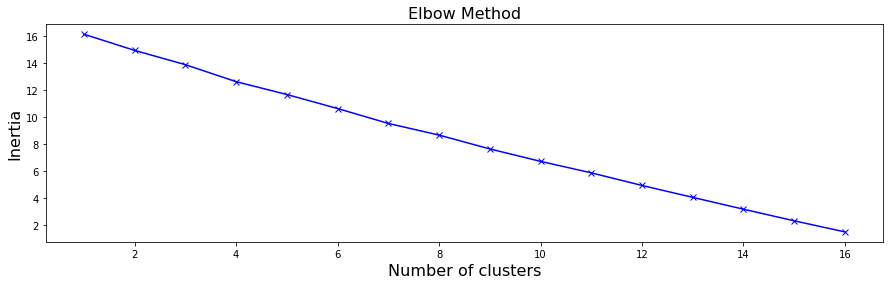

In [65]:
sum_of_squared_distances = []
K = range(1,tfidf.shape[0]-1)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(tfidf)
    sum_of_squared_distances.append(km.inertia_)


rcParams['figure.figsize'] = (15, 4)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters', fontsize=16)
plt.ylabel('Inertia', fontsize=16)
plt.title('Elbow Method', fontsize=16)
plt.show()    

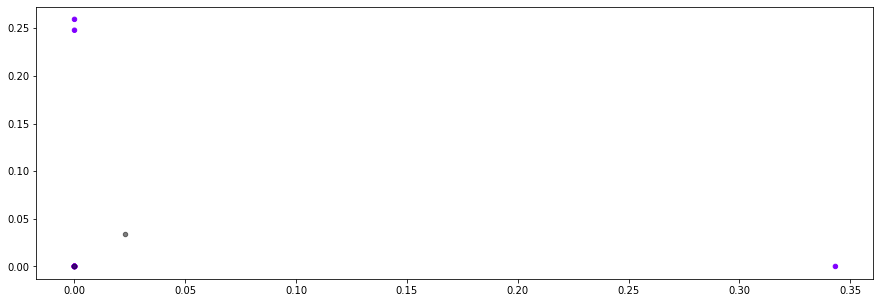

kmeans.labels_.shape: (18,)


Counter({0: 15, 1: 3})

In [68]:
#elbow fitted 
kmeans = KMeans(n_clusters=2)
kmeans.fit_transform(tfidf)
y_c = kmeans.cluster_centers_
labels_c = kmeans.labels_

rcParams['figure.figsize'] = (15, 5)
plt.scatter(tfidf[:,0], tfidf[:,1], c=kmeans.labels_, s=20, cmap='rainbow')
plt.scatter(y_c[:,0], y_c[:,1], s=20, alpha=0.5, color='black')
plt.show()

print('kmeans.labels_.shape:',kmeans.labels_.shape)
Counter(kmeans.labels_)

# FIM